# **PPP Computations**

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

from PIL import Image

%load_ext autoreload
%autoreload 2
import hmei.processing as pcs
import hmei.visualization as vis

# Import Data

Necessary data:
* control run variance
* ensemble timeseries

In [7]:
writedir = '/home/bbuchovecky/storage/so_predict_derived/'

pcs.dir_inspect(writedir+'SST_ENSEMBLE')

['sst_ens_global_annual_mean.nc',
 'sst_ens_global_monthly_anom.nc',
 'sst_ens_global_monthly_mean.nc',
 'sst_ens_so_annual_mean.nc',
 'sst_ens_so_monthly_anom.nc',
 'sst_ens_so_monthly_mean.nc']

In [6]:
pcs.dir_inspect(writedir+'CTRL/SST')

['SST_raw',
 'ocean.static.nc',
 'sst_gc_global_clim.nc',
 'sst_gc_global_monthly_anom.nc',
 'sst_gc_global_monthly_var.nc',
 'sst_gc_so_clim.nc',
 'sst_gc_so_monthly_anom.nc',
 'sst_gc_so_monthly_var.nc',
 'sst_so_gridcell_metrics.nc',
 'sst_ts_global_annual_mean.nc',
 'sst_ts_global_monthly_anom.nc',
 'sst_ts_global_monthly_mean.nc',
 'sst_ts_global_monthly_var.nc',
 'sst_ts_so_annual_mean.nc',
 'sst_ts_so_monthly_anom.nc',
 'sst_ts_so_monthly_mean.nc',
 'sst_ts_so_monthly_var.nc']

## Southern Ocean

In [77]:
def open_ctrl(var, timescale, reg='so'):
    writedir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    subdir = var.upper()+'/'
    filename = var.lower()+'_ts_'+reg+'_'+timescale+'_var.nc'
    
    return xr.open_dataset(writedir+subdir+filename)

sst_ctrl_so_var = open_ctrl('sst', 'monthly')
sss_ctrl_so_var = open_ctrl('sss', 'monthly')
mld_ctrl_so_var = open_ctrl('mld', 'monthly')
npp_ctrl_so_var = open_ctrl('npp', 'monthly')
sic_ctrl_so_var = open_ctrl('cn_inv', 'monthly')
sie_ctrl_so_var = open_ctrl('sie', 'monthly')
siv_ctrl_so_var = open_ctrl('siv', 'monthly')

In [78]:
def open_ens(var, timescale, reg='so'):
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir = var.upper()+'_ENSEMBLE/'
    filename = var.lower()+'_ens_'+reg+'_'+timescale+'_anom.nc'
    
    return xr.open_dataset(writedir+subdir+filename)

sst_ens_so_anom = open_ens('sst', 'monthly')
sss_ens_so_anom = open_ens('sss', 'monthly')
mld_ens_so_anom = open_ens('mld', 'monthly')
npp_ens_so_anom = open_ens('npp', 'monthly')
sic_ens_so_anom = open_ens('cn_inv', 'monthly')
sie_ens_so_anom = open_ens('sie', 'monthly')
siv_ens_so_anom = open_ens('siv', 'monthly')

## Global

In [79]:
def open_ctrl(var, timescale, reg='so'):
    writedir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    subdir = var.upper()+'/'
    filename = var.lower()+'_ts_'+reg+'_'+timescale+'_var.nc'
    
    return xr.open_dataset(writedir+subdir+filename)

sst_ctrl_global_var = open_ctrl('sst', 'monthly', reg='global')
sss_ctrl_global_var = open_ctrl('sss', 'monthly', reg='global')
mld_ctrl_global_var = open_ctrl('mld', 'monthly', reg='global')
npp_ctrl_global_var = open_ctrl('npp', 'monthly', reg='global')
sic_ctrl_global_var = open_ctrl('cn_inv', 'monthly', reg='global')
sie_ctrl_global_var = open_ctrl('sie', 'monthly', reg='global')
siv_ctrl_global_var = open_ctrl('siv', 'monthly', reg='global')

In [80]:
def open_ens(var, timescale, reg='so'):
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir = var.upper()+'_ENSEMBLE/'
    filename = var.lower()+'_ens_'+reg+'_'+timescale+'_anom.nc'
    
    return xr.open_dataset(writedir+subdir+filename)

sst_ens_global_anom = open_ens('sst', 'monthly', reg='global')
sss_ens_global_anom = open_ens('sss', 'monthly', reg='global')
mld_ens_global_anom = open_ens('mld', 'monthly', reg='global')
npp_ens_global_anom = open_ens('npp', 'monthly', reg='global')
sic_ens_global_anom = open_ens('cn_inv', 'monthly', reg='global')
sie_ens_global_anom = open_ens('sie', 'monthly', reg='global')
siv_ens_global_anom = open_ens('siv', 'monthly', reg='global')

# Compute PPP

$$ PPP(t) = 1 - \frac{\frac{1}{N(M - 1)} \sum\limits_{j=1}^{N} \sum\limits_{I=1}^{M} (X_{ij}(t) - \overline{X}_{j}(t))^{2}}{\sigma_{c}^{2}} $$

"where $X_{ij}(t)$ is the value of a given variable for the $j$th ensemble and $i$th ensemble member, $\overline{X}_{j}$ is the mean of the $j$th ensemble over all ensemble members, $\sigma_{c}^{2}$ is the variance of the control simulation, $N$ is the total number of different ensemble simulations ($N$=6) and $M$ the number of ensemble members ($M$=40)" - Froelicher et al. 2020

In [99]:
## variance of the control simulation for each month
## dimensions (month: 12)
ctrl = sst_ctrl_so_var.copy(deep=True)

## ensemble anomalies
## dimensions (nStart: 6, nEns: 40, nT: 120)
ens = sst_ens_so_anom.copy(deep=True)

reg = 'SouthernOcean'
N = 6
M = 40

## numerator coefficient
num_coeff = 1 / (N * (M - 1))

## numerator outer sum - across all ensembles
num_outer_sum = np.zeros((6,120))

for j in range(N):
    ## numerator inner sum - across all ensemble members
    num_inner_sum = np.zeros((40,120))

    ## ensemble mean
    ens_mean = ens[reg][j].mean(dim='nEns')
    
    for i in range(M):
        num_inner_sum[i] = np.square(ens[reg][j,i] - ens_mean)
        
    num_outer_sum[j] = np.sum(num_inner_sum, axis=0)

## numerator total sum
num_sum = np.sum(num_outer_sum, axis=0)

PPP = np.zeros(120)
for m in range(120):
    PPP[m] = 1 - ( (num_coeff * num_sum[m]) / np.square(ctrl[reg][m%12]).values )

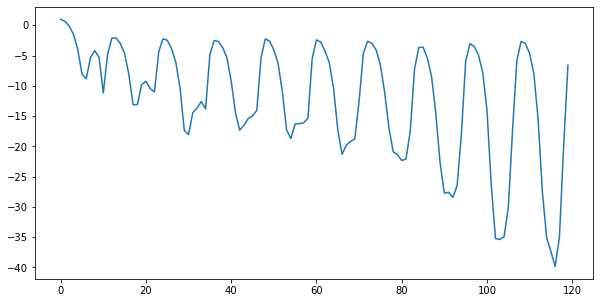

In [101]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(np.arange(120), PPP)

In [43]:
n = np.zeros((6,120))

n[0] = ens['SouthernOcean'][0,1] - ens['SouthernOcean'][0].mean(dim='nEns')

In [32]:
np.square(ens['SouthernOcean'][0].mean(dim='nEns'))

<xarray.DataArray 'SouthernOcean' (nT: 120)>
array([1.53589225e+00, 1.12016368e+00, 7.73103893e-01, 4.79836702e-01,
       2.57746488e-01, 1.59774259e-01, 1.15233079e-01, 9.17474478e-02,
       8.02865773e-02, 7.79270753e-02, 1.18841127e-01, 1.47903711e-01,
       1.18637651e-01, 6.00237325e-02, 4.17736955e-02, 4.05207872e-02,
       4.49845642e-02, 5.10354117e-02, 5.42403869e-02, 5.27766794e-02,
       5.25686592e-02, 5.76938614e-02, 7.22593814e-02, 8.42439607e-02,
       8.75233859e-02, 9.34179276e-02, 8.67306814e-02, 6.87209293e-02,
       6.52358308e-02, 5.51643446e-02, 5.04654795e-02, 4.83176596e-02,
       4.66067307e-02, 4.84824814e-02, 7.98944756e-02, 1.63533092e-01,
       1.95930779e-01, 1.76302344e-01, 1.39904365e-01, 1.08891651e-01,
       8.16974342e-02, 5.80661036e-02, 4.85453270e-02, 4.29295711e-02,
       4.09754179e-02, 4.29336764e-02, 6.43638223e-02, 7.11337700e-02,
       7.52063766e-02, 7.64159411e-02, 6.09713793e-02, 4.70475405e-02,
       4.56462167e-02, 4.23670895e-02, 3.29318158e-02, 2.78372318e-02,
       2.60006767e-02, 2.57285293e-02, 3.15737799e-02, 2.76910383e-02,
       4.39705737e-02, 4.45345491e-02, 3.73456664e-02, 2.94495560e-02,
       2.16700919e-02, 2.28974745e-02, 2.24220175e-02, 2.12378502e-02,
       1.88048389e-02, 1.71389561e-02, 2.06741523e-02, 2.37005223e-02,
       2.69485582e-02, 2.42379513e-02, 1.82746388e-02, 1.54433791e-02,
       1.23544028e-02, 1.32696442e-02, 1.25722755e-02, 1.22501478e-02,
       1.22788753e-02, 1.24965962e-02, 2.27559283e-02, 2.53381729e-02,
       2.41586715e-02, 2.38626506e-02, 1.74163375e-02, 1.08999703e-02,
       8.84465408e-03, 9.27290600e-03, 9.02015902e-03, 9.22521390e-03,
       8.52640998e-03, 8.67911708e-03, 1.28599666e-02, 7.90130999e-03,
       1.56992842e-02, 1.09395133e-02, 4.12671361e-03, 7.37568457e-03,
       8.91179685e-03, 1.13358032e-02, 9.48094577e-03, 8.29370786e-03,
       7.26081571e-03, 7.25314580e-03, 8.48110113e-03, 5.07832412e-03,
       9.64630512e-04, 3.20306327e-03, 2.98821973e-03, 2.25362694e-03,
       3.84176406e-03, 6.93736738e-03, 7.31448317e-03, 6.21319935e-03,
       5.37325116e-03, 5.05106803e-03, 8.20514839e-03, 6.51087658e-03],
      dtype=float32)
Coordinates:
  * nT       (nT) int64 1 2 3 4 5 6 7 8 9 ... 113 114 115 116 117 118 119 120
    nStart   <U9 '0170_0179'

In [52]:
np.sum(np.array([ [1,2,3], [4,5,6], [7,8,9] ]), axis=0)

array([12, 15, 18])